### colab 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import torch
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive/LG/lg_test')

In [ ]:
!pip install mmcv-full==1.6.0 -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -r requirements/build.txt
!pip install -v -e .
!pip install mmdet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
fatal: destination path 'mmdetection' already exists and is not an empty directory.
/content/drive/MyDrive/LG/lg_test/mmdetection
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
dis

## 데이터 다운 및 데이터 확인

### label_test.json 수정

In [ ]:
path = '/content/drive/MyDrive/LG/lg_test/data/dataset/'

In [ ]:
import json

with open(path + 'label_test.json') as f:
  data_train = json.load(f)

data_train['categories'] = [{'id': 1, 'name': 'Normal'}]

print(data_train.keys())

with open(path + 'test.json', 'w') as f:
    json.dump(data_train, f)

dict_keys(['images', 'categories'])


### mask r_cnn 사전 가중치 다운로드

In [ ]:
os.chdir('/content/drive/MyDrive/LG/lg_test/mmdetection/')
os.chdir('checkpoint')

from requests import get 

def download(url, file_name):
    with open(file_name, "wb") as file:   
        response = get(url)               
        file.write(response.content)


url = "https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_fpn_1x_coco/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth"
download(url,"mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth")

os.chdir('/content/drive/MyDrive/LG/lg_test/mmdetection/')

### config 지정

In [ ]:
import torch, torchvision
import mmcv
import mmdet
from mmcv.runner import load_checkpoint
from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector
from mmdet.apis import set_random_seed

In [ ]:
def set_config():
  # 사용할 모델 초기 py 설정
  config = './configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py'

  # config 불러오기
  cfg = mmcv.Config.fromfile(config)

  # config 에 base 기록
  cfg.base = '../configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py'

  # 데이터셋 지정
  cfg.dataset_type = 'CocoDataset'

  # data_root는 사용자가 저장한 데이터가 있는 폴더 전까지
  data_root = '/content/drive/MyDrive/LG/lg_test/data/dataset/'

  # class 설정
  cfg.classes = ('Normal',)

  # train, val, test 데이터셋에 대한 type, data_root, ann_file, img_prefix 설정

  cfg.data.samples_per_gpu=1
  cfg.data.workers_per_gpu=0

  cfg.data.train.data_root = data_root 
  cfg.data.train.ann_file = 'label(polygon)_train.json' 
  cfg.data.train.img_prefix = 'train/'
  cfg.data.train.classes = cfg.classes

  cfg.data.val.data_root = data_root
  cfg.data.val.ann_file = 'label(polygon)_train.json'
  cfg.data.val.img_prefix = 'train/'
  cfg.data.val.classes = cfg.classes

  cfg.data.test.data_root = data_root
  cfg.data.test.ann_file = 'test.json'
  cfg.data.test.img_prefix = 'test/'
  cfg.data.test.classes = cfg.classes

  # 클래스 수 지정
  cfg.model.roi_head.bbox_head.num_classes = 1
  cfg.model.roi_head.mask_head.num_classes = 1

  # 사전 훈련 모델 지정
  
  cfg.checkpoint_config = dict(interval=1,out_dir='work_dirs3/lg_mask/')

  # 가중치 저장 위치
  cfg.work_dir = './work_dirs4/lg_cfg2/'

  # 평가 지표로 설정
  cfg.evaluation.metric = ['bbox', 'segm']

  # epoch 설정
  cfg.runner = dict(type='EpochBasedRunner', max_epochs=5)

  # batch size 설정
  cfg.auto_scale_lr = dict(enable=False, base_batch_size=16)

  # gpu 설정 및 seed 설정
  cfg.seed = 0
  cfg.gpu_ids = range(1)
  cfg.device='cuda'


  return cfg

In [ ]:
cfg = set_config()

### 모델 훈련

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# dataset 생성 및 model 설정

datasets = [build_dataset(cfg.data.train)]
model = build_detector(cfg.model)
model.CLASSES = datasets[0].CLASSES

# 훈련
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.90s)
creating index...
index created!


2022-07-31 10:03:50,591 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.


loading annotations into memory...


2022-07-31 10:03:51,834 - mmdet - INFO - Start running, host: root@a7e6fe32d035, work_dir: /content/drive/MyDrive/LG/lg_test/mmdetection/work_dirs4/lg_cfg2
2022-07-31 10:03:51,843 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
 -------------------- 
after_train_iter:
(ABOVE

Done (t=1.17s)
creating index...
index created!


2022-07-31 10:04:31,302 - mmdet - INFO - Epoch [1][50/520]	lr: 1.978e-03, eta: 0:33:30, time: 0.788, data_time: 0.582, memory: 2274, loss_rpn_cls: 0.6490, loss_rpn_bbox: 0.2995, loss_cls: 0.4597, acc: 76.9844, loss_bbox: 0.1510, loss_mask: 0.6888, loss: 2.2480
2022-07-31 10:05:08,088 - mmdet - INFO - Epoch [1][100/520]	lr: 3.976e-03, eta: 0:31:44, time: 0.736, data_time: 0.549, memory: 2274, loss_rpn_cls: 0.5648, loss_rpn_bbox: 0.2972, loss_cls: 0.4120, acc: 79.6328, loss_bbox: 0.4318, loss_mask: 0.6537, loss: 2.3595
2022-07-31 10:05:45,842 - mmdet - INFO - Epoch [1][150/520]	lr: 5.974e-03, eta: 0:31:01, time: 0.755, data_time: 0.565, memory: 2316, loss_rpn_cls: 0.4629, loss_rpn_bbox: 0.2898, loss_cls: 0.4818, acc: 78.9453, loss_bbox: 0.5316, loss_mask: 0.6102, loss: 2.3762
2022-07-31 10:06:20,566 - mmdet - INFO - Epoch [1][200/520]	lr: 7.972e-03, eta: 0:29:44, time: 0.694, data_time: 0.507, memory: 2316, loss_rpn_cls: 0.4332, loss_rpn_bbox: 0.2984, loss_cls: 0.4607, acc: 78.3867, loss

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 520/520, 1.5 task/s, elapsed: 353s, ETA:     0s

2022-07-31 10:16:13,210 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.40s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=75.33s).
Accumulating evaluation results...


2022-07-31 10:17:30,686 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.292
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.196
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.196
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.196
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.084
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.204
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.54s).


/content/drive/MyDrive/LG/lg_test/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.63s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=78.08s).
Accumulating evaluation results...


/usr/local/lib/python3.7/dist-packages/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2022-07-31 10:18:51,745 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.285
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large

DONE (t=1.51s).


2022-07-31 10:19:28,448 - mmdet - INFO - Epoch [2][50/520]	lr: 2.000e-02, eta: 0:24:04, time: 0.731, data_time: 0.541, memory: 2407, loss_rpn_cls: 0.3222, loss_rpn_bbox: 0.2682, loss_cls: 0.4523, acc: 79.5195, loss_bbox: 0.6566, loss_mask: 0.4095, loss: 2.1089
2022-07-31 10:20:05,830 - mmdet - INFO - Epoch [2][100/520]	lr: 2.000e-02, eta: 0:23:34, time: 0.748, data_time: 0.557, memory: 2407, loss_rpn_cls: 0.3234, loss_rpn_bbox: 0.2877, loss_cls: 0.4525, acc: 79.2305, loss_bbox: 0.6465, loss_mask: 0.3838, loss: 2.0939
2022-07-31 10:20:41,051 - mmdet - INFO - Epoch [2][150/520]	lr: 2.000e-02, eta: 0:22:57, time: 0.704, data_time: 0.515, memory: 2407, loss_rpn_cls: 0.3002, loss_rpn_bbox: 0.2609, loss_cls: 0.4511, acc: 79.5586, loss_bbox: 0.6411, loss_mask: 0.3800, loss: 2.0334
2022-07-31 10:21:18,401 - mmdet - INFO - Epoch [2][200/520]	lr: 2.000e-02, eta: 0:22:26, time: 0.747, data_time: 0.555, memory: 2407, loss_rpn_cls: 0.3149, loss_rpn_bbox: 0.2736, loss_cls: 0.4522, acc: 79.5234, loss

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 520/520, 1.6 task/s, elapsed: 321s, ETA:     0s

2022-07-31 10:30:33,912 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.38s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=74.52s).
Accumulating evaluation results...


2022-07-31 10:31:50,616 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.123
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.316
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.143
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.181
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.227
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.227
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.227
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.094
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.59s).


/content/drive/MyDrive/LG/lg_test/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.69s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=75.87s).
Accumulating evaluation results...


/usr/local/lib/python3.7/dist-packages/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2022-07-31 10:33:09,563 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.141
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.321
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.161
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large

DONE (t=1.54s).


2022-07-31 10:33:46,644 - mmdet - INFO - Epoch [3][50/520]	lr: 2.000e-02, eta: 0:17:43, time: 0.739, data_time: 0.549, memory: 2407, loss_rpn_cls: 0.2748, loss_rpn_bbox: 0.2685, loss_cls: 0.4521, acc: 79.8633, loss_bbox: 0.6347, loss_mask: 0.3646, loss: 1.9947
2022-07-31 10:34:23,131 - mmdet - INFO - Epoch [3][100/520]	lr: 2.000e-02, eta: 0:17:10, time: 0.730, data_time: 0.539, memory: 2407, loss_rpn_cls: 0.2755, loss_rpn_bbox: 0.2618, loss_cls: 0.4566, acc: 79.5234, loss_bbox: 0.6199, loss_mask: 0.3554, loss: 1.9692
2022-07-31 10:35:00,252 - mmdet - INFO - Epoch [3][150/520]	lr: 2.000e-02, eta: 0:16:37, time: 0.742, data_time: 0.551, memory: 2407, loss_rpn_cls: 0.2745, loss_rpn_bbox: 0.2569, loss_cls: 0.4467, acc: 79.9180, loss_bbox: 0.6310, loss_mask: 0.3611, loss: 1.9702
2022-07-31 10:35:36,560 - mmdet - INFO - Epoch [3][200/520]	lr: 2.000e-02, eta: 0:16:02, time: 0.726, data_time: 0.535, memory: 2407, loss_rpn_cls: 0.2526, loss_rpn_bbox: 0.2525, loss_cls: 0.4575, acc: 79.6523, loss

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 520/520, 1.6 task/s, elapsed: 334s, ETA:     0s

2022-07-31 10:45:03,693 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.40s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=74.07s).
Accumulating evaluation results...


2022-07-31 10:46:19,924 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.162
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.385
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.218
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.266
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.266
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.266
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.274
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.55s).


/content/drive/MyDrive/LG/lg_test/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.69s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=74.80s).
Accumulating evaluation results...


/usr/local/lib/python3.7/dist-packages/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2022-07-31 10:47:37,775 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.388
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.194
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large

DONE (t=1.52s).


2022-07-31 10:48:15,826 - mmdet - INFO - Epoch [4][50/520]	lr: 2.000e-02, eta: 0:11:34, time: 0.758, data_time: 0.569, memory: 2407, loss_rpn_cls: 0.2541, loss_rpn_bbox: 0.2472, loss_cls: 0.4364, acc: 80.4062, loss_bbox: 0.6045, loss_mask: 0.3462, loss: 1.8884
2022-07-31 10:48:52,834 - mmdet - INFO - Epoch [4][100/520]	lr: 2.000e-02, eta: 0:11:00, time: 0.740, data_time: 0.550, memory: 2407, loss_rpn_cls: 0.2514, loss_rpn_bbox: 0.2504, loss_cls: 0.4486, acc: 80.1914, loss_bbox: 0.6106, loss_mask: 0.3600, loss: 1.9210
2022-07-31 10:49:30,208 - mmdet - INFO - Epoch [4][150/520]	lr: 2.000e-02, eta: 0:10:26, time: 0.747, data_time: 0.556, memory: 2407, loss_rpn_cls: 0.2643, loss_rpn_bbox: 0.2544, loss_cls: 0.4438, acc: 80.5312, loss_bbox: 0.6135, loss_mask: 0.3507, loss: 1.9267
2022-07-31 10:50:07,163 - mmdet - INFO - Epoch [4][200/520]	lr: 2.000e-02, eta: 0:09:52, time: 0.739, data_time: 0.549, memory: 2407, loss_rpn_cls: 0.2605, loss_rpn_bbox: 0.2476, loss_cls: 0.4551, acc: 79.3672, loss

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 520/520, 1.5 task/s, elapsed: 343s, ETA:     0s

2022-07-31 10:59:41,003 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.39s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=74.01s).
Accumulating evaluation results...


2022-07-31 11:00:57,149 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.415
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.128
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.192
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.227
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.53s).


/content/drive/MyDrive/LG/lg_test/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.67s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=74.96s).
Accumulating evaluation results...


/usr/local/lib/python3.7/dist-packages/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2022-07-31 11:02:15,115 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.418
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.170
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.118
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large

DONE (t=1.51s).


2022-07-31 11:02:51,961 - mmdet - INFO - Epoch [5][50/520]	lr: 2.000e-02, eta: 0:05:28, time: 0.734, data_time: 0.545, memory: 2407, loss_rpn_cls: 0.2272, loss_rpn_bbox: 0.2343, loss_cls: 0.4415, acc: 80.2070, loss_bbox: 0.6088, loss_mask: 0.3398, loss: 1.8517
2022-07-31 11:03:28,262 - mmdet - INFO - Epoch [5][100/520]	lr: 2.000e-02, eta: 0:04:54, time: 0.726, data_time: 0.536, memory: 2407, loss_rpn_cls: 0.2299, loss_rpn_bbox: 0.2431, loss_cls: 0.4402, acc: 80.3086, loss_bbox: 0.6046, loss_mask: 0.3354, loss: 1.8532
2022-07-31 11:04:04,829 - mmdet - INFO - Epoch [5][150/520]	lr: 2.000e-02, eta: 0:04:19, time: 0.731, data_time: 0.541, memory: 2407, loss_rpn_cls: 0.2323, loss_rpn_bbox: 0.2336, loss_cls: 0.4428, acc: 80.3320, loss_bbox: 0.6009, loss_mask: 0.3423, loss: 1.8519
2022-07-31 11:04:41,914 - mmdet - INFO - Epoch [5][200/520]	lr: 2.000e-02, eta: 0:03:44, time: 0.742, data_time: 0.551, memory: 2407, loss_rpn_cls: 0.2247, loss_rpn_bbox: 0.2393, loss_cls: 0.4404, acc: 80.3320, loss

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 520/520, 1.8 task/s, elapsed: 290s, ETA:     0s

2022-07-31 11:13:26,846 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.39s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=72.91s).
Accumulating evaluation results...


2022-07-31 11:14:41,912 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.193
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.435
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.146
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.128
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.214
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.303
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.303
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.303
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.173
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.55s).


/content/drive/MyDrive/LG/lg_test/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.67s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=74.48s).
Accumulating evaluation results...


/usr/local/lib/python3.7/dist-packages/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2022-07-31 11:15:59,428 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.207
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.437
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large

DONE (t=1.52s).


#### 결과 이미지 시각화

/content/drive/MyDrive/LG/lg_test/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


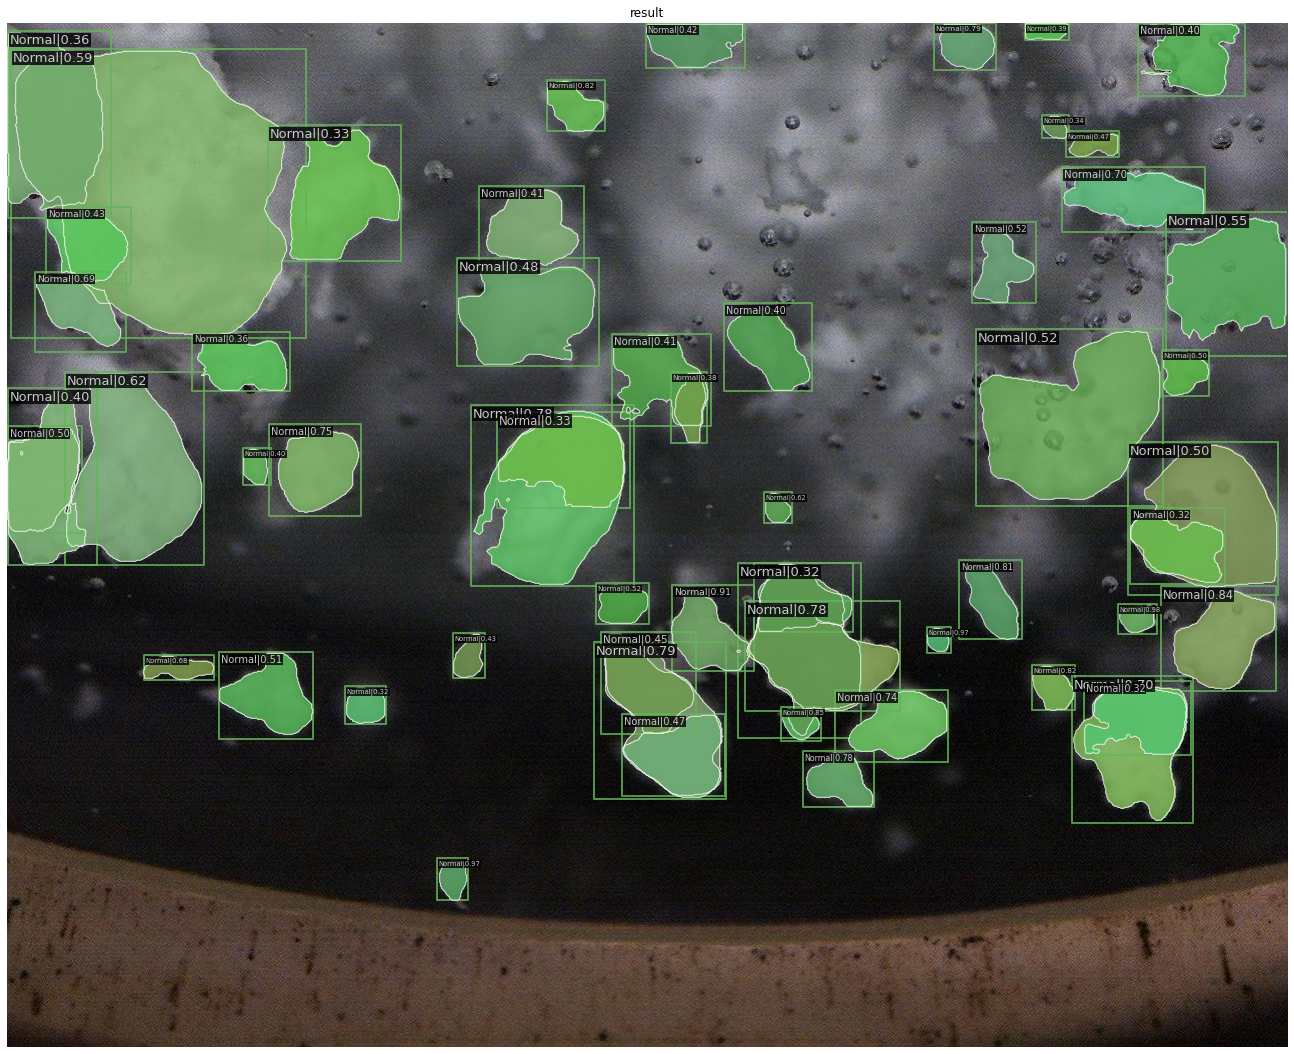

In [ ]:
img = mmcv.imread('/content/drive/MyDrive/LG/lg_test/data/dataset/test/0058.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

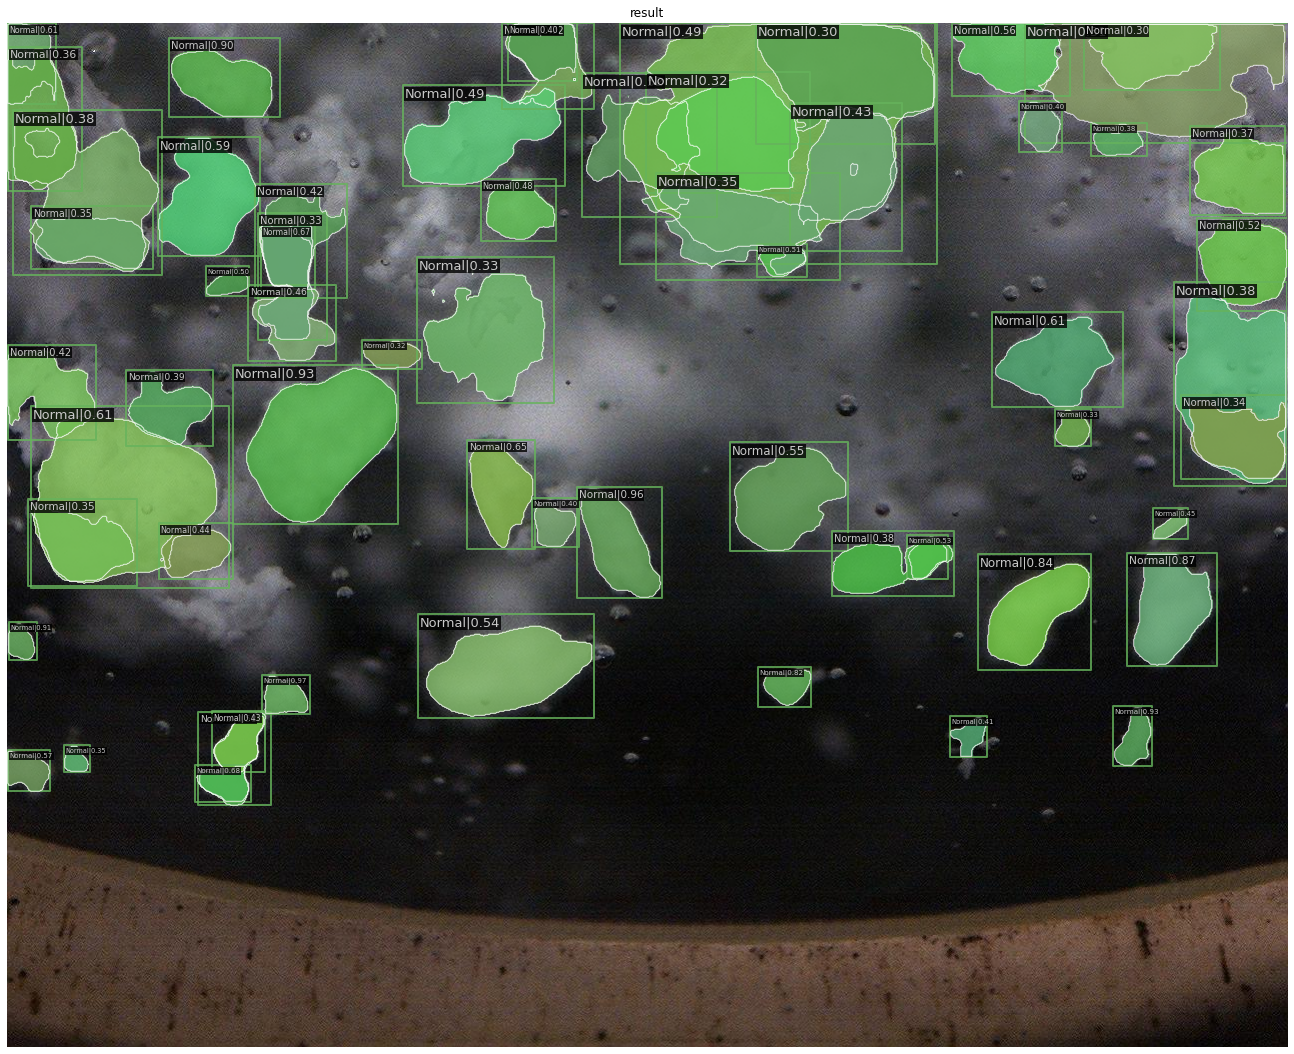

In [ ]:
img = mmcv.imread('/content/drive/MyDrive/LG/lg_test/data/dataset/test/0087.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

&nbsp;

### 모델 테스트 및 out json 확인

- 해당 코드는 mmdetection/tools/test.py 의 내용중에서 cfg를 바로 사용할수 있게 수정한 코드입니다.
- 추가적인 기능을 수행할때는 작동하지 않을수 있습니다. test.py 내용 확인은 해당 링크를 참조하시면 감사하겠습니다. 
[test.py](https://github.com/open-mmlab/mmdetection/blob/master/tools/test.py)


&nbsp;

- test를 수행하기 전에 cfg 기존 설정 다시 실행
- train을 수행하면서 설정된 내부 파라미터 초기화 위해서

In [ ]:
cfg = set_config()

In [ ]:
import argparse
import os
import os.path as osp
import time
import warnings

import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.cnn import fuse_conv_bn
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
                         wrap_fp16_model)

from mmdet.apis import multi_gpu_test, single_gpu_test
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.utils import (build_ddp, build_dp, compat_cfg, get_device,
                         replace_cfg_vals, setup_multi_processes,
                         update_data_root)





# 필요한 파라미터 설정
checkpoint='work_dirs/lg_mask/lg_cfg2/latest.pth' # 훈련시킨 모델 가중치
show=False
show_dir=None
show_score_thr=0.34
eval_options={'jsonfile_prefix': './work_dirs/out_json4/predict'} # json 출력 저장위치
format_only = True
out = None





## 여기서 부터 기존의 mmdetection/tools/test.py 를 변경한 코드 ##

cfg = replace_cfg_vals(cfg)
update_data_root(cfg)
cfg = compat_cfg(cfg)
setup_multi_processes(cfg)



# set cudnn_benchmark
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True

if 'pretrained' in cfg.model:
    cfg.model.pretrained = None
elif 'init_cfg' in cfg.model.backbone:
    cfg.model.backbone.init_cfg = None

if cfg.model.get('neck'):
    if isinstance(cfg.model.neck, list):
        for neck_cfg in cfg.model.neck:
            if neck_cfg.get('rfp_backbone'):
                if neck_cfg.rfp_backbone.get('pretrained'):
                    neck_cfg.rfp_backbone.pretrained = None
    elif cfg.model.neck.get('rfp_backbone'):
        if cfg.model.neck.rfp_backbone.get('pretrained'):
            cfg.model.neck.rfp_backbone.pretrained = None



cfg.gpu_ids = [cfg.gpu_ids]
cfg.device = get_device()


distributed = False


test_dataloader_default_args = dict(
    samples_per_gpu=1, workers_per_gpu=2, dist=distributed, shuffle=False)

# in case the test dataset is concatenated
if isinstance(cfg.data.test, dict):
    cfg.data.test.test_mode = True
    if cfg.data.test_dataloader.get('samples_per_gpu', 1) > 1:
        # Replace 'ImageToTensor' to 'DefaultFormatBundle'
        cfg.data.test.pipeline = replace_ImageToTensor(
            cfg.data.test.pipeline)
elif isinstance(cfg.data.test, list):
    for ds_cfg in cfg.data.test:
        ds_cfg.test_mode = True
    if cfg.data.test_dataloader.get('samples_per_gpu', 1) > 1:
        for ds_cfg in cfg.data.test:
            ds_cfg.pipeline = replace_ImageToTensor(ds_cfg.pipeline)

test_loader_cfg = {
    **test_dataloader_default_args,
    **cfg.data.get('test_dataloader', {})
}

rank, _ = get_dist_info()


# build the dataloader
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(dataset, **test_loader_cfg)

# build the model and load checkpoint
cfg.model.train_cfg = None
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))

fp16_cfg = cfg.get('fp16', None)
if fp16_cfg is not None:
    wrap_fp16_model(model)
checkpoint = load_checkpoint(model, checkpoint, map_location='cpu')


if 'CLASSES' in checkpoint.get('meta', {}):
    model.CLASSES = checkpoint['meta']['CLASSES']
else:
    model.CLASSES = dataset.CLASSES

if not distributed:
    model = build_dp(model, cfg.device, device_ids=cfg.gpu_ids)
    outputs = single_gpu_test(model, data_loader, show, show_dir,
                              show_score_thr)


rank, _ = get_dist_info()
if rank == 0:
    if out:
        print(f'\nwriting results to {out}')
        mmcv.dump(outputs, out)
    kwargs = {} if eval_options is None else eval_options
    if format_only:
        dataset.format_results(outputs, **kwargs)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
load checkpoint from local path: work_dirs/lg_mask/lg_cfg2/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 350/350, 1.8 task/s, elapsed: 195s, ETA:     0s

&nbsp;

### 최종 결과물은 predict.segm.json 형식으로 제출

In [ ]:
import json

with open("/content/drive/MyDrive/LG/lg_test/mmdetection/work_dirs/out_json4/predict.bbox.json") as f:
    out_data3 = json.load(f)

with open("/content/drive/MyDrive/LG/lg_test/mmdetection/work_dirs/out_json4/predict.segm.json") as g:
    out_data4 = json.load(g)

In [ ]:
# 테스트 결과 json 원본
fr=open("/content/drive/MyDrive/LG/lg_test/mmdetection/work_dirs/out_json4/predict.segm.json")


# single quote -> double quote로 변환해 저장할 파일
fw=open("/content/drive/MyDrive/LG/predicted.segm.fixed4.json", "w")

In [ ]:
for line in fr:
    l = line.replace("'", "\"")
    fw.write(l)
fw.close()
fr.close()

In [ ]:
# double quote로 고쳐진 파일 다시 열어서 list 형태로 변환
with open("/content/drive/MyDrive/LG/predicted.segm.fixed4.json") as json_file:
    json_data = json.load(json_file)

In [ ]:
#각 annotation과 관련된 dict 담을 배열 생성
annotation_list = []

In [ ]:
# json_data를 지나면서 필요한 정보(image_id, segmentation[size, counts]) dict에 담아 저장
for box in json_data:
    new_dict = {}
    new_dict["image_id"] = box["image_id"]
    new_dict["segmentation"] ={"size":box["segmentation"]["size"], "counts":box["segmentation"]["counts"]}
    annotation_list.append(new_dict)

In [ ]:
# 저장된 정보 annotations dict로 묶기
final_dict = {"annotations": annotation_list}

In [ ]:
# submission.json에 파일 열어서 생성한 포맷된 json형태로 담기 
fw = open("/content/drive/MyDrive/LG/lg_test/data/dataset/sample_submission4.json", "w")
json.dump(final_dict,fw, indent=2, separators=(',', ': '))
fw.close()

In [ ]:
with open("/content/drive/MyDrive/LG/lg_test/data/dataset/sample_submission4.json") as g:
    sb_data3 = json.load(g)

In [ ]:
sb_data3

{'annotations': [{'image_id': 0,
   'segmentation': {'counts': 'ne_a08go03M2N2N2N2N2O2M2O0O2O2M2O1N2O1N2O001N1O2O0O1N2O1O1O2N100O100O100O1O100O100O100O1O100O10000000000000O1000001O00001O1O001N2O1O1O1O1O1O1N3N1O1O1O1O1O1N2O1O1O2M3N1N4LRZnc0',
    'size': [1024, 1280]}},
  {'image_id': 0,
   'segmentation': {'counts': 'fal?1io0<G6L3L3O2M2O1O1O001O10O2O0O100O2N1O1O2O0O100O1O010O1O001O001O10O01N2O1N3Nm]mf0',
    'size': [1024, 1280]}},
  {'image_id': 0,
   'segmentation': {'counts': 'Xd_77ho03M2N2K4SOGoQO=nm0ImQO:Pn0ImQO9Rn0HnQO8Qn0KiQO9Vn0i000O10000O10000O010O01N1O2N1O2N2N2N2O1N2O1O1O2N1O3M3M2O3L3M4K7Gk\\Vo0',
    'size': [1024, 1280]}},
  {'image_id': 0,
   'segmentation': {'counts': 'gc[f05ho06L3L5L2N2N3M2O1N2O1N101O000001O001O1N2O001N100O1O10O01O0O2O1N2N2N3M2Nc\\``0',
    'size': [1024, 1280]}},
  {'image_id': 0,
   'segmentation': {'counts': 'fcgT18go05[OIoPOL2d0in0`0L4L3J5N3L211N1O1000000010O001O00001O0000O010O0O1O01O1O1O1O2N1O2O1N2O1O1N2O1O1M3N3M2O2N1O2N2N1O2N3M>^OW]b1',
    'size':